In [1]:
%pylab inline
import gc
import galsim
import numpy as np
import astropy.io.fits as pyfits

import fpfsBase

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sympy
from sympy.series import series
x,y,a,b = sympy.var('x,y,a,b')
expr=(a+y)**2*(b+x)/(1+x)**3
expr.series(x,x0=0,n=3).removeO().series(y,x0=0,n=3).removeO()

6*a**2*b*x**2 - 3*a**2*b*x + a**2*b - 3*a**2*x**2 + a**2*x + y**2*(6*b*x**2 - 3*b*x + b - 3*x**2 + x) + y*(12*a*b*x**2 - 6*a*b*x + 2*a*b - 6*a*x**2 + 2*a*x)

In [3]:
x,y,a,b = sympy.var('x,y,a,b')
expr=(a+y)**2/(1+x)**2
expr.series(x,x0=0,n=3).removeO().series(y,x0=0,n=3).removeO()

3*a**2*x**2 - 2*a**2*x + a**2 + y**2*(3*x**2 - 2*x + 1) + y*(6*a*x**2 - 4*a*x + 2*a)

In [4]:
cd wrkDir/FPFS2/sim

/lustre/work/xiangchong.li/work/FPFS2/sim


+ corrections for ellipticity, response and flux ratio 

$\frac{x}{1+x}=x-x^2$

$\frac{y}{1+x}=y(1-x)$

$\frac{a}{1+x}=a(1-x+x^2)$

$\frac{a^2}{(1+x)^2}=a^2(1-2x+3x^2)$

$\frac{(a+y)^2}{(1+x)^2}=a^2(1-2x+3x^2)+y^2+2ay(1-2x)$

$\frac{(a+y)^2(b+x)}{(1+x)^3}=(a+y)^2(b+x)(1-3x+6x^2)$

$(a^2b+2aby+by^2+a^2x+2axy+xy^2)(1-3x+6x^2)$


$a^2b(1+6x^2)+2aby(1-3x)+a^2x(1-3x)+by^2+2axy$


$a^2b(1+6x^2)-3a^2x^2+by^2+2a(1-3b)xy$


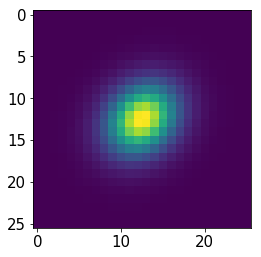

In [5]:
ngrid=64
nx=100;ny=100
ngal=nx*ny
psfFWHM=0.60
scale=0.168
igal=89
beta=0.75

hsmCat=pyfits.getdata('galaxy_basic_psf%d/hsm-0-g1-2222.fits' %(psfFWHM*100))
rcutArray=np.maximum(np.minimum(np.int_(hsmCat['regauss_detR']*5),15),11)
rcut=rcutArray[igal]
    
beg=ngrid//2-rcut
end=beg+2*rcut
galImgAll=pyfits.getdata('galaxy_basic_psf%d/image-0-g1-2222.fits' %(psfFWHM*100))
img=galImgAll[igal//nx*ngrid+beg:igal//nx*ngrid+end,igal%nx*ngrid+beg:igal%nx*ngrid+end]/10.
plt.imshow(img)

In [6]:
# Initialize the fpfsTask
psfInt  =   galsim.Moffat(beta=3.5,fwhm=psfFWHM,trunc=psfFWHM*4.)
psfInt  =   psfInt.shear(e1=0.02,e2=-0.02)
psfImg  =   psfInt.drawImage(nx=64,ny=64,scale=scale)
psfData =   psfImg.array[beg:end,beg:end]
fpTask0=fpfsBase.fpfsTask(psfData,beta=beta)

a0=fpTask0.measure(img)
C=12
b0=fpfsBase.fpfsM2E(a0,C)
print(a0,a0.dtype.names)
print(b0,b0.dtype.names)

(505.61906161, 1.57699595, 60.39571237, 25.30104185) ('fpfs_M00', 'fpfs_M22c', 'fpfs_M22s', 'fpfs_M40')
[(0.00304663, 0.11667985, 0.66578398, 0.97681693, 0.01362347, 0.00022333)] ('fpfs_e1', 'fpfs_e2', 'fpfs_RE', 'fpfs_s0', 'fpfs_eSquare', 'fpfs_RS')


In [22]:
# Noise
corPre      =   'corPre'
corFname    =   os.path.join(corPre,'correlation.fits')
variance    =   8e-3
ngrid=64

if False:
    corIn=pyfits.getdata(corFname)*variance
    corIn=np.pad(corIn,(23-32+rcut,22-32+rcut))

    corNum=np.fft.fftshift(np.fft.ifft2(np.abs(np.fft.fft2(np.ones(img.shape)))**2.)).real
    corIn=corIn*corNum
    powIn=np.fft.fftshift(np.fft.fft2(np.fft.fftshift(corIn)).real)
else:
    powIn=np.load('corPre/noiPows2.npy',allow_pickle=True).item()['%s'%rcut]*variance*100
powModel=np.zeros((1,img.shape[0],img.shape[1]))
powModel[0]=powIn
#fpTask=fpfsBase.fpfsTask(psfData,noiModel=powModel)
fpTask=fpfsBase.fpfsTask(psfData,noiFit=powModel[0],beta=beta)

In [23]:
%%time

import numpy.lib.recfunctions as rfn
a=[]
for j in range(0,40):
    noiAll=pyfits.getdata('noise/noi%04d.fits' %j)*np.sqrt(variance*100.)
    imgList=[noiAll[i//nx*ngrid+beg:i//nx*ngrid+end,i%nx*ngrid+beg:i%nx*ngrid+end]+img for i in range(ngal)]
    #plt.imshow(imgList[5])
    res=fpTask.measure(imgList)
    a.append(res)
    del noiAll,imgList
    gc.collect()
a =   rfn.stack_arrays(a,usemask=False)

CPU times: user 3min 36s, sys: 13.6 s, total: 3min 49s
Wall time: 3min 49s


In [24]:
print('variance of N00 from simulation and equation:')
print(np.var(a['fpfs_M00']),np.average(a['fpfs_N00N00']))
print('variance of N40 from simulation and equation:')
print(np.var(a['fpfs_M40']),np.average(a['fpfs_N40N40']))
print('variance of N22c from simulation and equation:')
print(np.var(a['fpfs_M22c']),np.average(a['fpfs_N22cN22c']))
print('variance of N22s from simulation and equation:')
print(np.var(a['fpfs_M22s']),np.average(a['fpfs_N22sN22s']))
print('cov of N22cN00 from simulation and equation:')
print(np.average(a['fpfs_M22c']*a['fpfs_M00'])-np.average(a['fpfs_M22c'])*np.average(a['fpfs_M00']),np.average(a['fpfs_N00N22c']))
print('cov of N22cN00 from simulation and equation:')
print(np.average(a['fpfs_M22s']*a['fpfs_M00'])-np.average(a['fpfs_M22s'])*np.average(a['fpfs_M00']),np.average(a['fpfs_N00N22s']))
print('cov of N40N00 from simulation and equation:')
print(np.average(a['fpfs_M40']*a['fpfs_M00'])-np.average(a['fpfs_M40'])*np.average(a['fpfs_M00']),np.average(a['fpfs_N00N40']))

variance of N00 from simulation and equation:
5050.225702106892 5286.8136477831595
variance of N40 from simulation and equation:
18374.855854047288 18213.530682010078
variance of N22c from simulation and equation:
3683.6595921280546 3509.828368022964
variance of N22s from simulation and equation:
3595.500484121538 3542.2743725562777
cov of N22cN00 from simulation and equation:
60.16223833030108 58.98813318469724
cov of N22cN00 from simulation and equation:
476.18565066403244 463.95659345556925
cov of N40N00 from simulation and equation:
-403.56907060438243 -96.74389497240918


In [25]:
%%time
b=fpfsBase.fpfsM2E(a,C)

CPU times: user 36.5 ms, sys: 7.92 ms, total: 44.4 ms
Wall time: 43.6 ms


In [26]:
print('Discrepancy in ellipticities and Response')
print('e1:',np.average(b['fpfs_e1'])-np.average(b0['fpfs_e1']))
print('e2:',np.average(b['fpfs_e2'])-np.average(b0['fpfs_e2']))
print('esq1:',np.average(b['fpfs_e1']**2.)-np.average(b0['fpfs_e1']**2.))
print('esq2:',np.average(b['fpfs_e2']**2.)-np.average(b0['fpfs_e2']**2.))
print('s0:',np.average(a['fpfs_M00']/(a['fpfs_M00']+C))-np.average(a0['fpfs_M00']/(a0['fpfs_M00']+C)))
print('s4:',np.average(a['fpfs_M40']/(a['fpfs_M00']+C))-np.average(a0['fpfs_M40']/(a0['fpfs_M00']+C)))
print('RE:',np.average(b['fpfs_RE'])-np.average(b0['fpfs_RE']))
print('e1sqS:',np.average(b['fpfs_e1']**2.*(a['fpfs_M00']/(a['fpfs_M00']+C)))-np.average(b0['fpfs_e1']**2.*(a0['fpfs_M00']/(a0['fpfs_M00']+C))))
print('e2sqS:',np.average(b['fpfs_e2']**2.*(a['fpfs_M00']/(a['fpfs_M00']+C)))-np.average(b0['fpfs_e2']**2.*(a0['fpfs_M00']/(a0['fpfs_M00']+C))))

Discrepancy in ellipticities and Response
e1: 9.052564915531906e-05
e2: 0.000625889304633101
esq1: 0.013869219478191752
esq2: 0.01357726403197622
s0: -0.0004475274542624641
s4: 0.002929547773575257
RE: 0.01701964181558313
e1sqS: 0.013536676471046064
e2sqS: 0.013242542913471387


In [27]:
# e
ratio=a['fpfs_N00N00']/(a['fpfs_M00']+C)**2.
e1=np.average((b['fpfs_e1']+a['fpfs_N00N22c']/(a['fpfs_M00']+C)**2.)/(1+ratio))
e2=np.average((b['fpfs_e2']+a['fpfs_N00N22s']/(a['fpfs_M00']+C)**2.)/(1+ratio))
print(e1-np.average(b0['fpfs_e1']),e1/np.average(b0['fpfs_e1'])-1)
print(e2-np.average(b0['fpfs_e2']),e2/np.average(b0['fpfs_e2'])-1)

0.00024537463335484646 0.08053957726842453
4.4810054714516934e-05 0.0003840427997707785


In [28]:
e1sq=np.average((b['fpfs_e1']**2.-a['fpfs_N22cN22c']/(a['fpfs_M00']+C)**2.+4.*b['fpfs_e1']*a['fpfs_N00N22c']/(a['fpfs_M00']+C)**2.)/(1.+3*ratio))
e2sq=np.average((b['fpfs_e2']**2.-a['fpfs_N22sN22s']/(a['fpfs_M00']+C)**2.+4.*b['fpfs_e2']*a['fpfs_N00N22s']/(a['fpfs_M00']+C)**2.)/(1.+3*ratio))
print(e1sq-np.average(b0['fpfs_e1']**2.),e1sq/np.average(b0['fpfs_e1']**2.)-1)
print(e2sq-np.average(b0['fpfs_e2']**2.),e2sq/np.average(b0['fpfs_e2']**2.)-1)

0.0013083040874938222 140.95096788926455
0.0008261670784884753 0.06068427823445943


In [29]:
#s0 s4
s0=np.average((a['fpfs_M00']/(a['fpfs_M00']+C)+a['fpfs_N00N00']/(a['fpfs_M00']+C)**2.)/(1+ratio))
s4=np.average((a['fpfs_M40']/(a['fpfs_M00']+C)+a['fpfs_N00N40']/(a['fpfs_M00']+C)**2.)/(1+ratio))
RE=(s0-s4+e1sq+e2sq)/np.sqrt(2.)
print(s0-np.average(a0['fpfs_M00']/(a0['fpfs_M00']+C)))
print(s4-np.average(a0['fpfs_M40']/(a0['fpfs_M00']+C)))
print(RE-np.average(b0['fpfs_RE']))

2.7407407201529566e-05
0.0017363134056021315
0.00030092001583381656


In [30]:
print(e1/RE-np.average(b0['fpfs_e1'])/np.average(b0['fpfs_RE']))
print(e2/RE-np.average(b0['fpfs_e2'])/np.average(b0['fpfs_RE']))

0.0003663160939207733
-1.1900467364100997e-05


In [31]:
print(np.average(b['fpfs_e1'])/np.average(b['fpfs_RE'])-np.average(b0['fpfs_e1'])/np.average(b0['fpfs_RE']))
print(np.average(b['fpfs_e2'])/np.average(b['fpfs_RE'])-np.average(b0['fpfs_e2'])/np.average(b0['fpfs_RE']))

1.8517178088869185e-05
-0.0034517005758934183


$a^2b(1+6x^2)-3a^2x^2+by^2+2a(1-3b)xy$

In [32]:
tmp=a['fpfs_M00']/(a['fpfs_M00']+C)
e1sqS=b['fpfs_e1']**2.*tmp+3.*b['fpfs_e1']**2.*a['fpfs_N00N00']/(a['fpfs_M00']+C)**2.-tmp*a['fpfs_N22cN22c']/(a['fpfs_M00']+C)**2.
e1sqS=np.average(e1sqS/(1+6.*ratio))
e2sqS=b['fpfs_e2']**2.*tmp+3.*b['fpfs_e2']**2.*a['fpfs_N00N00']/(a['fpfs_M00']+C)**2.-tmp*a['fpfs_N22sN22s']/(a['fpfs_M00']+C)**2.
e2sqS=np.average(e2sqS/(1+6.*ratio))
print(e1sqS-np.average(b0['fpfs_e1']**2.*a0['fpfs_M00']/(a0['fpfs_M00']+C)))
print(e2sqS-np.average(b0['fpfs_e2']**2.*a0['fpfs_M00']/(a0['fpfs_M00']+C)))

0.0011704319273318782
5.6424438635455446e-05


In [33]:
b2=fpfsBase.fpfsM2E(a,C,rev=True)

In [34]:
print(np.average(b2['fpfs_e1']-b0['fpfs_e1']))
print(np.average(b2['fpfs_e2']-b0['fpfs_e2']))
print(np.average(b2['fpfs_RE']-b0['fpfs_RE']))
print(np.average(b2['fpfs_s0']-b0['fpfs_s0']))
print(np.average(b2['fpfs_e1'])/np.average(b2['fpfs_RE'])-np.average(b0['fpfs_e1'])/np.average(b0['fpfs_RE']))
print(np.average(b2['fpfs_e2'])/np.average(b2['fpfs_RE'])-np.average(b0['fpfs_e2'])/np.average(b0['fpfs_RE']))
print(np.average(b2['fpfs_eSquare'])-np.average(b0['fpfs_eSquare']))
print(np.average(b2['fpfs_RS'])-np.average(b0['fpfs_RS']))

0.00024537463335484424
4.481005471455383e-05
0.00029576956160980936
2.74074072018549e-05
0.0003663543104026126
-1.0545426756658483e-05
0.002127187323765911
0.0016245225410272005


In [35]:
print(np.average(b['fpfs_e1']-b0['fpfs_e1']))
print(np.average(b['fpfs_e2']-b0['fpfs_e2']))
print(np.average(b['fpfs_RE']-b0['fpfs_RE']))
print(np.average(b['fpfs_s0']-b0['fpfs_s0']))
print(np.average(b['fpfs_e1'])/np.average(b['fpfs_RE'])-np.average(b0['fpfs_e1'])/np.average(b0['fpfs_RE']))
print(np.average(b['fpfs_e2'])/np.average(b['fpfs_RE'])-np.average(b0['fpfs_e2'])/np.average(b0['fpfs_RE']))
print(np.average(b['fpfs_eSquare'])-np.average(b0['fpfs_eSquare']))
print(np.average(b['fpfs_RS'])-np.average(b0['fpfs_RS']))

9.052564915531798e-05
0.0006258893046331005
0.01701964181558338
-0.00044752745426254194
1.8517178088869185e-05
-0.0034517005758934183
0.027446483510167985
0.0004718269880900021
